<a href="https://colab.research.google.com/github/TottiPuc/Machine_learning/blob/master/Regresion_lineal_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Regresión Lineal

A diferencia de los algoritmos de clasificación que tienen como objetivo predecir las etiquetas de clase categoricas (discretas) de nuevas instancias  basadas en observaciones pasadas, la regresión lineal es otro tipo de aprendizaje supervisado que permite preveer valores numericos osea hacer una prediccion de resultados continuos, en elcual se cuenta con variables predictoras **explicativas** y una variable de respuesta continua **destino**

In [0]:
#importar imagenes desde archivos locales
from google.colab import files
from IPython.display import Image

upload = files.upload()

Saving Regresion.png to Regresion (1).png


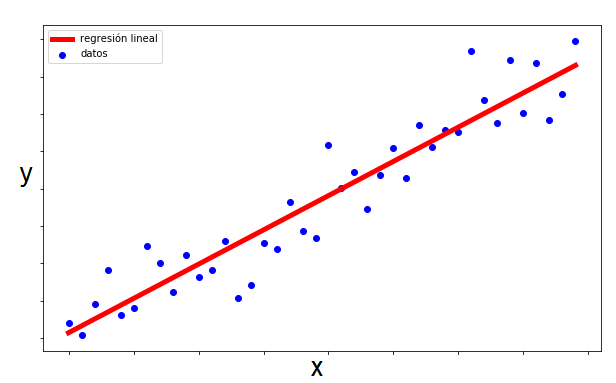

In [0]:
Image('Regresion (1).png',width=600)

La grafica de regresón puede interpretarse de la siguiente forma: 
Dada una variable predictora *X* y una variable de destino *y* se aplica una linea que minimize la distancia entre los datos de muestra y la linea, normalmente para la regresión lineal usaremos el error cuadrático medio.

El modelo general definido para una regresión esta dado por:

$y = WX +b$

donde *X* y *y* representan los datos de entrada y de salida respectivamente, mientras que *W* y *b* representan los coeficientes o intersección y pendiente que deben ser aprendidos segun los datos que se tienen. siendo *W* el conjunto de N pesos y *X* la matriz de entrada de N características.



#Regresión lineal con tensorflow

En esta sección se entrenara un modelo de regresion lineal capaz de preveer la posibilidad de admisión de un alumno a una determinada universidad,dadas las algunas de sus caracteristicas. Para llevar acabo el entrenamiento se usara un dataset disponible en [(dataset)](https://www.apb.ucla.edu/campus-statistics/common-data-set) el cual esta conformado por parametros que son considerados importantes durante la inscripción en los programas de maestria. 

El dataset consta de las siguientes características:

1. Puntuación GRE (GRE Score hasta 340) 
2. Puntuación del TOEFL (TOEFL Score hasta120) 
3. Clasificación de la universidad (University Rating hasta 5) 
4. Declaracion de objetivo (SOP hasta 5) 
5. Impacto de la carta de recomendación (LOR hasta 5) 
6. Pregrado GPA (CGPA hasta 10) 
7. Experiencia en investigación (Research 0 o 1) 
8. Posibilidad de admisión (Chance of Admit variando de 0 a 1) - variable objetivo

In [0]:
!pip install tensorflow-gpu==2.0.0-alpha0

In [0]:
#impotando modulos necesarios
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
from sklearn.model_selection import train_test_split # función que permite dividir el dataset en conjunto de entrenamiento y teste 

In [3]:
# cargando el dataset
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [4]:
import io
data = pd.read_csv(io.BytesIO(uploaded['data.csv']))
# El Dataset esta ahora almacenado en un Pandas Dataframe
data.tail()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
495,496,332,108,5,4.5,4.0,9.02,1,0.87
496,497,337,117,5,5.0,5.0,9.87,1,0.96
497,498,330,120,5,4.5,5.0,9.56,1,0.93
498,499,312,103,4,4.0,5.0,8.43,0,0.73
499,500,327,113,4,4.5,4.5,9.04,0,0.84


Lo primero que se debe tener en cuenta y analizar en el dataset es si las variables son categoricas o numericas, esto se realiza con el fin de poder dar un tratamiento adecuado al conjunto de datos ya que una variable categorica como es Research en el dataset cargado anteriormente no se debe normalizar.

##Preparación de datos

Lo primero que se debe realizar con los conjuntos de datos de entrada es escalar el conjunto de caracteristicas. En este caso se escalan solo las caracteristicas numericas 

In [0]:
#normalizando variables
caracteristicas_continuas = data[['GRE Score','TOEFL Score','University Rating','SOP','LOR','CGPA']].values/100
caracteristicas_categoricas = data[['Research']].values
#concatenar variables para tener de nuevo el dataset original normalizado
X = np.concatenate([caracteristicas_continuas,caracteristicas_categoricas],axis=1) #con axis=1 se concatena en columnas sin el parametro axis se concatena en filas
Y = data[['Chance of Admit']].values


Con los datos escalados, se hace la división del total del dataset en los correspondientes conjuntos de entrenamineto y teste una metrica normal es usar el 80% para entrenamiento y el 20% para teste 

In [0]:
#Separando datos en entrenamiento y teste
train_caracteristicas, test_caracteristicas, train_etiquetas, test_etiquetas = train_test_split(X,Y,test_size=0.2) # la variable test_size=0.2 indica que del total de datos del dataset se usara 
                                                                                                                    # el 20% para teste y el 80% para entrenamiento
#convertir los datos de entrenamiento y de teste en tensores

X_train = tf.constant(train_caracteristicas,dtype=tf.float32)
Y_train = tf.constant(train_etiquetas,dtype=tf.float32)

X_test = tf.constant(test_caracteristicas,dtype=tf.float32)
Y_test = tf.constant(test_etiquetas, dtype=tf.float32)


###Clase principal de regresión lineal
Con el preprocesamiento de los datos y la separación en entrenamiento y teste, se procede con el algoritmo de aprendizaje (Regresion lineal), cuyo objetivo es encontrar los parámetros adecuados de los pesos *W* que minimicen el [error cuadràtico medio](https://en.wikipedia.org/wiki/Mean_squared_error) entre los resultados reales ofrecidos por el dataset y los estimados por el modelo.

In [0]:
class Regresion(object):

  def __init__(self, numero_epocas=10, tasa_aprendizaje=0.001, tamano_lote=10, semilla=1):
    #inicialización de hiperparametros
    self.numero_epocas=numero_epocas
    self.tasa_aprendizaje=tasa_aprendizaje
    self.tamano_lote=tamano_lote
    self.semilla=semilla

  def alg_aprendizaje(self,X,y):
    self.numero_caracteristicas = X.shape[1]
    self.numero_muestras = X.shape[0]
    self.pesos,self.bias = self.inicializar_pesos(self.numero_caracteristicas)
    self.coste=[]
    self.iteraciones=[]

    #Obteniendo las muestras de datos para el entrenamiento y creando un iterador
    dataset=tf.data.Dataset.from_tensor_slices((X_train,Y_train)) #divide los datos de entreno en tensores individuales
    #for data in dataaset:
    #  print(data)
    dataset=dataset.shuffle(500).repeat(self.numero_epocas).batch(self.tamano_lote) #mezcla el dataset 500 veces, concatena cada mezcla un numero repetido de veces y extrae un lote para entrenar
    iterador =dataset.__iter__() # se genera un iterador el cual ofrecera cada lote para entrenamiento

    print('\n Entrenamiento principal')

    for i in range(self.numero_epocas):
      self.perdida_por_iteracion = list()

      for b in range(int(self.numero_muestras/self.tamano_lote)):
        x_lote ,y_lote = iterador.get_next()  # pido el proximo lote mezclado de entrenamiento
        salida = self.entrada_red(x_lote)
        perdida = self.perdida_por_iteracion.append(self.error_medio_cuadratico(y_lote,salida).numpy())

        dJ_dH = self.derivada(y_lote,salida)
        dH_dW = x_lote
        dJ_dW = tf.reduce_mean(dJ_dH * dH_dW)
        dJ_dB = tf.reduce_mean(dJ_dH)

        self.pesos -=  (self.tasa_aprendizaje * dJ_dW)
        self.bias -= (self.tasa_aprendizaje * dJ_dB)
        
      perdida = np.array(self.perdida_por_iteracion).mean()
      self.iteraciones.append(i+1)
      self.coste.append(perdida)

      print("La tasa de error es igual a {}".format(perdida))
    return self


  def error_medio_cuadratico(self,Y,y_predict): # funcion de coste
    return tf.reduce_mean(tf.square(y_predict - Y))

  def derivada(self, Y,y_predict):
    return tf.reshape(tf.reduce_mean(2*(y_predict-Y)),[1,1])

  def entrada_red(self, X):
    return tf.tensordot(X,self.pesos,axes=1) + self.bias  # axes=1 realiza el producto punto axes=0 producto matricial


  def inicializar_pesos(self,dim):
    pesos_iniciados = tf.random.normal([dim + 1],seed=self.semilla)
    pesos = pesos_iniciados[1:]
    bias = pesos_iniciados[0]
    return pesos, bias
       

Se crea un objeto para realizar el entrenamiento y las futuras predicciones

In [20]:
reg = Regresion()
reg.alg_aprendizaje(X_train,Y_train)


 Entrenamiento principal
La tasa de error es igual a 1.0207927227020264
La tasa de error es igual a 0.6905701160430908
La tasa de error es igual a 0.5410441160202026
La tasa de error es igual a 0.46899089217185974
La tasa de error es igual a 0.4387804865837097
La tasa de error es igual a 0.42789536714553833
La tasa de error es igual a 0.41403451561927795
La tasa de error es igual a 0.41801509261131287
La tasa de error es igual a 0.41641759872436523
La tasa de error es igual a 0.41845837235450745


###graficas de regresión

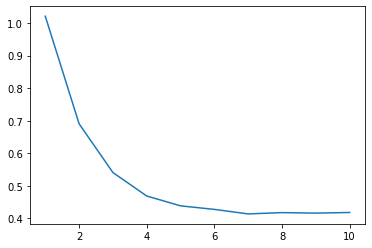

In [21]:
import matplotlib.pyplot as plt
plt.plot(reg.iteraciones, reg.coste)
plt.show()

se puede observar como la tasa de error disminuye conforme pasan las iteraciones, aproximadamente con 5 iteraciones se obtiene un optimo desempeño, alcanzando un erro menor a 0.5

### Teste del modelo de regresión

In [23]:
salida = reg.entrada_red(X_test)
etiquetas = Y_test

#calculo de acierto

accuracy_op = tf.metrics.MeanAbsoluteError()
accuracy_op.update_state(etiquetas,salida)
print("Error Medio Cuadratico (MAE) = {}".format(accuracy_op.result().numpy()))

print("un estudiante con las siguientes caracteristicas: ")
tf.print(X_test[1,:])
print("tendria el siguiente porcentaje de ser admitido en la universidad")
tf.print(Y_test[1]*100)

Error Medio Cuadratico (MAE) = 0.5589649677276611
un estudiante con las siguientes caracteristicas: 
[3.29 1.11 0.04 ... 0.04 0.0923 1]
tendria el siguiente porcentaje de ser admitido en la universidad
[89]
